In [2]:
library(tidyverse)
library(tidymodels)
library(readxl)
library(repr)
library(DBI)
library(dbplyr)
library(RPostgres)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

# DSCI 100 Group Project Proposal
## Group 8: Mikki, Muhammed, Tony Daisy 

### Introduction

We will be using the multivariable Heart Disease Data in the UCI Machine Learning Repository (1988) to predict the presence of cardiovascular disease. In this dataset, the presence of cardiovascular disease is determined by the vessel diameter narrowing. Lower than 50% diameter narrowing in patients is assumed to indicate the absence of heart disease. On the other hand, higher than 50% diameter narrowing in patients is assumed to indicate the presence of heart disease. We hope to determine whether ST depression (Kligfield, P., 2006) induced by exercise relative to rest (oldpeak), age, maximum heart rate achieved (thalach), and cholesterol levels (chol) of patients can predict the presence of cardiovascular disease. 

### Preliminary Explanatory Data Analysis

New names:
• `1.0` -> `1.0...2`
• `1.0` -> `1.0...3`
• `1.0` -> `1.0...6`
• `0.0` -> `0.0...9`
• `0.0` -> `0.0...12`
Rows: 302 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): 0.0...12, 6.0
dbl (12): 63.0, 1.0...2, 1.0...3, 145.0, 233.0, 1.0...6, 2.0, 150.0, 0.0...9...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


chol,trestbps,cvd,age,thalach,oldpeak
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
286,160,2,67,108,1.5
229,120,1,67,129,2.6
250,130,0,37,187,3.5
204,130,0,41,172,1.4
236,120,0,56,178,0.8
268,140,3,62,160,3.6


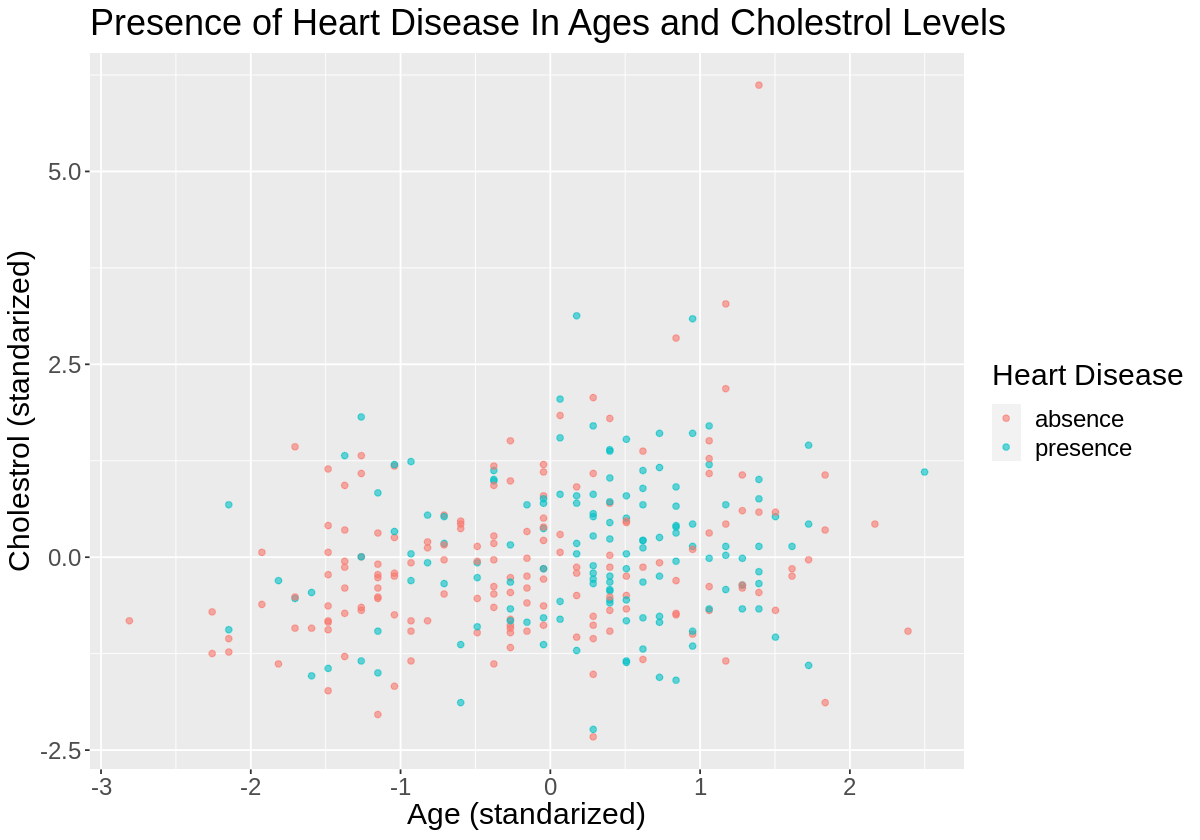

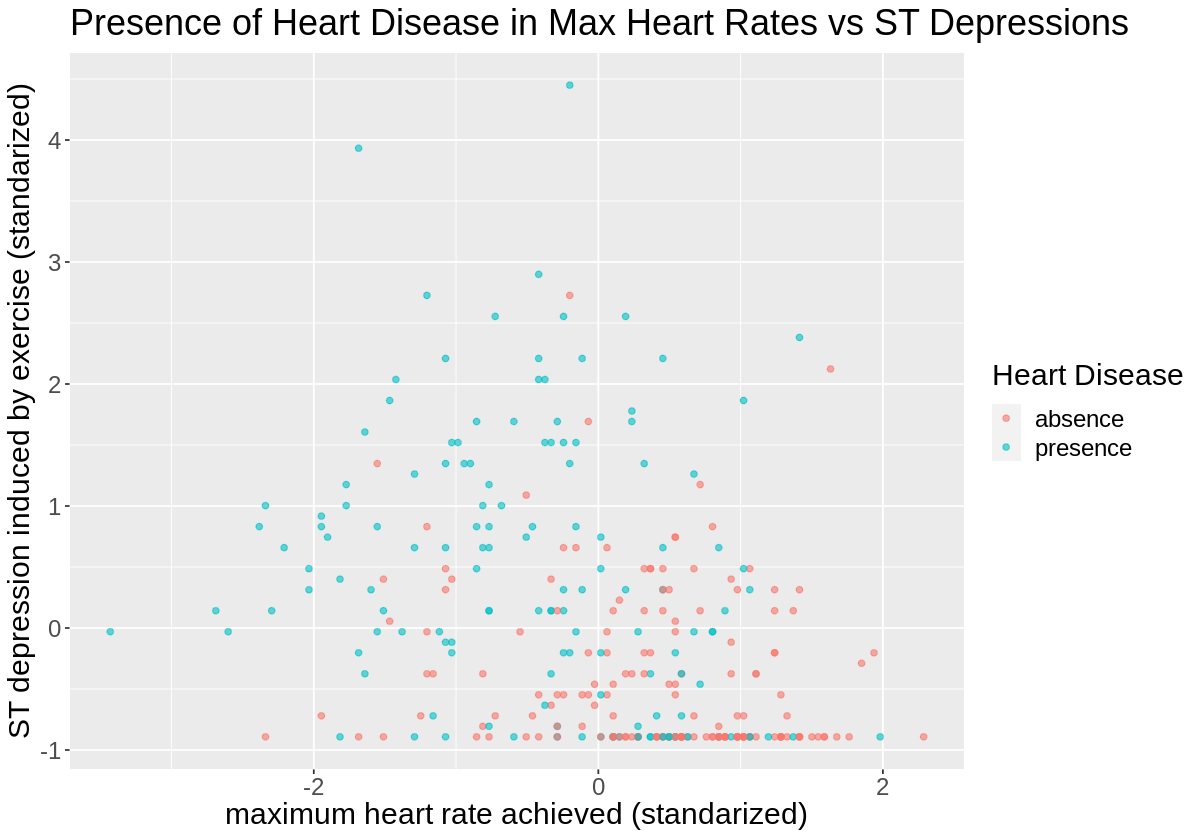

In [3]:
options(repr.plot.width=10, repr.plot.height=7)

url<-"https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
heart_data_raw<-read_csv(url)
colnames(heart_data_raw)<- c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "cvd")
heart_data<-heart_data_raw %>%
    select(chol, trestbps, cvd, age, thalach, oldpeak) 

head(heart_data)
heart_data$cvd[heart_data$cvd == "2"] <- "1"
heart_data$cvd[heart_data$cvd == "3"] <- "1"
heart_data$cvd[heart_data$cvd == "4"] <- "1"
heart_data$cvd[heart_data$cvd == "1"] <- "presence"
heart_data$cvd[heart_data$cvd == "0"] <- "absence"

#split data into training part and testing part
hd_split<- initial_split(heart_data,prop=0.75, strata = cvd)
hd_train <- training(hd_split)
hd_test <- testing(hd_split)

#preprocesss data
hd_recipe <- recipe(cvd~chol+trestbps + age + thalach + oldpeak,data = heart_data)|>
step_scale(all_predictors())|>
step_center(all_predictors())|>
prep()
scaled_hd<- bake(hd_recipe,heart_data)

#i changed title of num to cvd, and replaced all values indication presence of cvd with yes or no
heart_data_plot<-scaled_hd %>%
    ggplot(aes(x = age , y = chol, color = cvd)) +
    geom_point(alpha = 0.6) +
    labs(x = "Age (standarized)" , y = "Cholestrol (standarized)", color = "Heart Disease") +
    theme(text = element_text(size = 18)) +
    ggtitle("Presence of Heart Disease In Ages and Cholestrol Levels") #feel free to change this

heart_data_plot

#Resting Systolic Blood Pressure (mmHg)
heart_data_plot_age <- scaled_hd |>
ggplot(aes(x = thalach , y = oldpeak, color = cvd)) +
    geom_point(alpha = 0.6) +
    labs(x = "maximum heart rate achieved (standarized)" , y = "ST depression induced by exercise (standarized)", color = "Heart Disease") +
    theme(text = element_text(size = 18)) + 
    ggtitle("Presence of Heart Disease in Max Heart Rates vs ST Depressions") 

heart_data_plot_age


### Methods

By splitting the dataset into two groups, we can determine the accuracy of the model based upon whether the predictions frequently match the observed heart disease presence. We have standardized and visualized the selected variables to view the relationship between each predictor and the presence of heart disease within our training group. ST depression (Miranda et al., 1991), age (Sandvik, L., et al., 1995), cholestrol, and max heart rate (Jeong et al., 2018) were all chosen because previous research has shown their ability to indicate circulatory health; especially in the context of cardiovascular disease onset. Areas predominately containing one color of dots may suggest a strong relationship to cardiovascular disease (such as increased ST depression levels being predominately CVD present). Before using K-Nearest Neighbors and Classification for predicting our test set values, we will determine the best K value using cross validation of values between 1 and 150 (since there are about 150 data points in each group). Finally, the accuracy of the best K value within our model will be applied to our test group to determine the accuracy of our final model.

### Predictions and Significance

   Out of all the selected response variables (cholestrol, maximum heart rate, age, and ST depression), our group predicts that all variables will adequately predict the presence of cardiovascular disease. However, we also infer that ST depression and age will have the strongest relationship with the onset of cardiovascular disease. Specifically, ST depression and age would be positively correlated to CVD, while both cholestrol and heart rate will be negatively correlated. 
    According to previous research, both ST depression and age have strong potential to predict the onset of heart disease (Sandvik, L., et al., 1995)(National Institutes of Health, 2018). Previous research has also depicted a correlation between fluctuating cholestrol and heart disease deaths (BMJ, 2009), however the data is less definitive in comparison. 
    Determining the presence of a strong relatinship  would significantly improve our ability to prevent cardivascular disease mortality in patients. Futher investigation could improve such a model and ideally result in it's clinical application in healthcare. 

### Citations

    Citations
   Asia Pacific Cohort Studies Collaboration, Nov 21st (2005), Joint Effectos of Systolic Blood Pressure and Serum Cholestrol on Cardiovascular Disease in the Asia Pacific Region, 112:3384-3390, https://www.ahajournals.org/doi/full/10.1161/CIRCULATIONAHA.105.537472
   BMJ, Feb 16th (2009), Assicoation between Change in High Density Lipoprotein Cholestrol and Cardiovascular Disease Morbidity and Mortality: Systematic Review and Meta-regression Analysis, 338;b92
https://www.bmj.com/content/338/bmj.b92.short 
    Jeong, Su-Min, et al., (2018). Effect of Change in Total Cholesterol Levels on Cardiovascular Disease Among Young Adults. Journal of the American Heart Association, Vol. 7, No 12.DOI: 10.1161/JAHA.118.008819 
https://www.ahajournals.org/doi/10.1161/JAHA.118.008819
    Kligfield, Paul, Lauer, Michael S., Nov 7 (2006), Exercise Electrocardiogram Testing: Beyond the ST Segment, 114;2070-2082, https://www.ahajournals.org/doi/10.1161/CIRCULATIONAHA.105.561944
    Miranda, C. P., Lehmann, K. G., & Froelicher, V. F. (1991). Correlation between resting ST segment depression, exercise testing, coronary angiography, and long-term prognosis. American heart journal, 122(6), 1617–1628. 
https://pubmed.ncbi.nlm.nih.gov/1957757/
    National Institutes of Health, June 1st (2018), Heart Health and Aging, 
https://www.nia.nih.gov/health/heart-health-and-aging
    Sandvik, L., Erikssen, J., Ellestad, M., Erikssen, G., Thaulow, E., Mundal, R., Rodahl, K., August 6th (1995), Heart Rate Increases and Maximal Heart Rate during Excercise as Predictors of Cardiovascular Mortality: A 16-year Follow-up Study of 1960 Healthy Men, (8):667-79, 
https://pubmed.ncbi.nlm.nih.gov/8574463/
   UCI Machine Learning Repository, (1988), Heart Disease Data Set,
https://archive.ics.uci.edu/ml/datasets/Heart+Disease